# Pre-work

## Set-up

In [1]:
!pip install tensorflow==1.2.0
!pip install keras==2.0.9

import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
import io

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

seed = 7
np.random.seed(seed)

import tensorflow as tf
import pandas as pd
from pandas import Series,DataFrame

import io
from io import StringIO

from statistics import mean 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn import preprocessing

%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.ticker as ticker

import collections

from keras import backend as k
# from tensorflow.python.framework import ops
# ops.reset_default_graph()    

Using TensorFlow backend.


## Process Data

In [0]:
def data_process():
  uploaded = files.upload()
  for fn in uploaded.keys():
    fn
  data = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
  data = data.iloc[:, 1:] # remove date col cuz it's meaningless here
  # data['Date_col_name'] = pd.to_datetime(data['Date_col_name'],unit='s') if here is timestamp
  data = data.astype('float64')
  data.info()
  
  return data

In [3]:
Data = data_process()

Saving DryCreek_input_add_label.csv to DryCreek_input_add_label (1).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6044 entries, 0 to 6043
Data columns (total 19 columns):
1-day aggregated anomaly LG Mean daily Q m^3/s    6044 non-null float64
LWR_P (precipitation)                             6044 non-null float64
LWR_T (temperature)                               6044 non-null float64
LWR_SWE (snow water equivalent)                   6044 non-null float64
LWR_Melt (snow melt)                              6044 non-null float64
LWR_ET (evapotranspiration)                       6044 non-null float64
TL_P                                              6044 non-null float64
TL_T                                              6044 non-null float64
TL_SWE                                            6044 non-null float64
TL_Melt                                           6044 non-null float64
TL_ET                                             6044 non-null float64
LWR_Soil1 (soil moisture at 1

### feature selection

*   Univariate selection
*   Recursive Feature Elimination (RFE)
*   Principle Component Analysis (PCA)
*   Choosing important features (feature importance)

Reference:

https://machinelearningmastery.com/feature-selection-machine-learning-python/

https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0

Recursive Feature Elimination (RFE)

In [4]:
Y = Data.iloc[:,0].values
X = Data.iloc[:,1:].values

# feature extraction
'''
The Recursive Feature Elimination (or RFE) works by recursively removing attributes and building a model on those attributes that remain.
'''
model = LinearRegression(fit_intercept=True, normalize=True)
rfe = RFE(model, 10)
fit = rfe.fit(X, Y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 10
Selected Features: [ True False False False False False False False False  True  True  True
  True  True  True  True  True  True]
Feature Ranking: [1 3 6 4 2 9 5 8 7 1 1 1 1 1 1 1 1 1]


In [5]:
Data.columns

Index(['1-day aggregated anomaly LG Mean daily Q m^3/s',
       'LWR_P (precipitation)', 'LWR_T (temperature)',
       'LWR_SWE (snow water equivalent)', 'LWR_Melt (snow melt)',
       'LWR_ET (evapotranspiration)', 'TL_P', 'TL_T', 'TL_SWE', 'TL_Melt',
       'TL_ET', 'LWR_Soil1 (soil moisture at 10 cm deep)', 'LWR_Soil5',
       'LWR_Soil6', 'LWR_Soil10', 'TL_Soil1', 'TL_Soil5', 'TL_Soil6',
       'TL_Soil10'],
      dtype='object')

In [6]:
for i in range(0,18):
  if fit.support_[i] == True:
    print(list(Data.columns.values)[i+1]) # exclude the label column

LWR_P (precipitation)
TL_ET
LWR_Soil1 (soil moisture at 10 cm deep)
LWR_Soil5
LWR_Soil6
LWR_Soil10
TL_Soil1
TL_Soil5
TL_Soil6
TL_Soil10


Choosing important features (feature importance)

In [7]:
from sklearn.ensemble import RandomForestRegressor

# feature extraction
Y = Data.iloc[:,0].values
X = Data.iloc[:,1:].values
model = RandomForestRegressor()
model.fit(X, Y)
print(model.feature_importances_)

[0.01290162 0.00753885 0.00231382 0.0005489  0.02286223 0.01459409
 0.00689413 0.02534547 0.00951152 0.02339857 0.04209558 0.34717689
 0.03014404 0.05219507 0.0329863  0.12299139 0.02179429 0.22470724]


In [8]:
for i in range(0,18):
  if model.feature_importances_[i] > 0.02:
    print(list(Data.columns.values)[i+1]) # exclude the label column

LWR_ET (evapotranspiration)
TL_SWE
TL_ET
LWR_Soil1 (soil moisture at 10 cm deep)
LWR_Soil5
LWR_Soil6
LWR_Soil10
TL_Soil1
TL_Soil5
TL_Soil6
TL_Soil10


correlation features

In [0]:
#!pip install feature-selector
from feature_selector import FeatureSelector

In [10]:
fs = FeatureSelector(data = Data, labels = Data.iloc[:,0])
fs.identify_collinear(correlation_threshold = 0.90)

6 features with a correlation magnitude greater than 0.90.



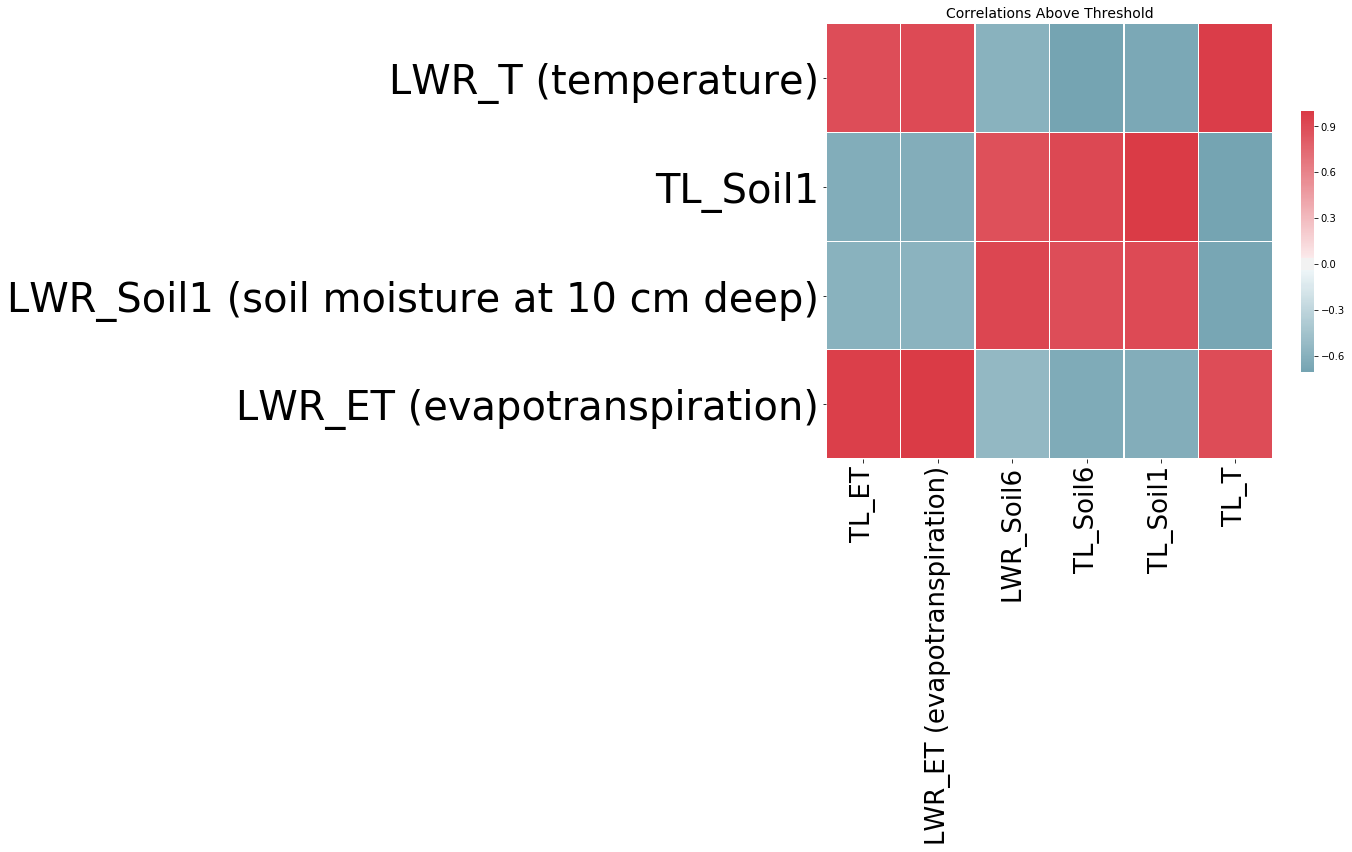

In [11]:
fs.plot_collinear()

In [12]:
# list of collinear features to remove
collinear_features = fs.ops['collinear']
# dataframe of collinear features
fs.record_collinear.head()

,drop_feature,corr_feature,corr_value
0,LWR_ET (evapotranspiration),LWR_T (temperature),0.905802
1,TL_T,LWR_T (temperature),0.979716
2,TL_ET,LWR_ET (evapotranspiration),0.970539
3,LWR_Soil6,LWR_Soil1 (soil moisture at 10 cm deep),0.929765
4,TL_Soil1,LWR_Soil1 (soil moisture at 10 cm deep),0.902479


In [0]:
Data = Data.drop(['TL_T', 'TL_ET', 'LWR_ET (evapotranspiration)', 'LWR_Soil6', 'TL_Soil1'], axis=1)

Column Selected

In [14]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6044 entries, 0 to 6043
Data columns (total 14 columns):
1-day aggregated anomaly LG Mean daily Q m^3/s    6044 non-null float64
LWR_P (precipitation)                             6044 non-null float64
LWR_T (temperature)                               6044 non-null float64
LWR_SWE (snow water equivalent)                   6044 non-null float64
LWR_Melt (snow melt)                              6044 non-null float64
TL_P                                              6044 non-null float64
TL_SWE                                            6044 non-null float64
TL_Melt                                           6044 non-null float64
LWR_Soil1 (soil moisture at 10 cm deep)           6044 non-null float64
LWR_Soil5                                         6044 non-null float64
LWR_Soil10                                        6044 non-null float64
TL_Soil5                                          6044 non-null float64
TL_Soil6                     

**Visualize data**

what color do you want? k


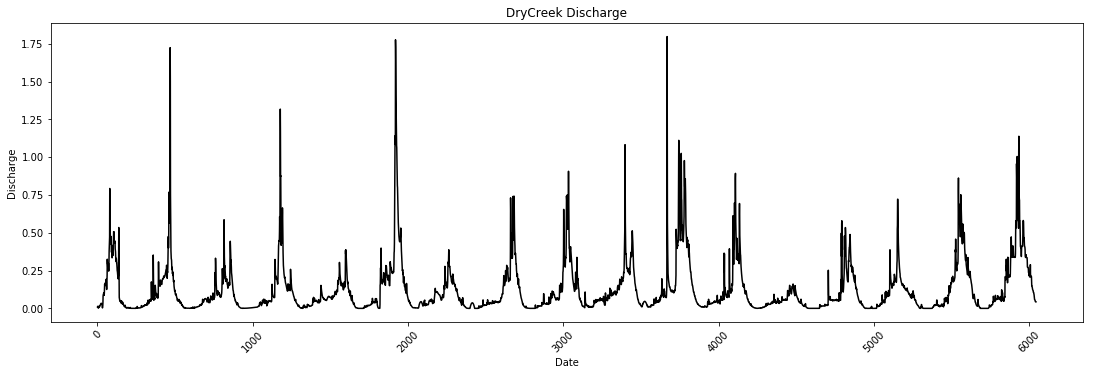

In [15]:
# plot the overall data
# Data.plot(figsize=(18,7))

# create the plot space upon which to plot the data
fig, ax= plt.subplots()

# add the x-axis and the y-axis to the plot
ax.plot(Data['1-day aggregated anomaly LG Mean daily Q m^3/s'], 
        color = input('what color do you want? '))

# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45)

# set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Discharge",
       title="DryCreek Discharge");

# set plot size
fig.set_size_inches(18.5, 5.5)

# Nested Cross Validation

**Day Forward-Chaining Nested Cross-Validation**

![alt text](https://miro.medium.com/max/2056/1*2-zaRQ-dsv8KWxOlzc8VaA.png)
*source: https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9*

Here, I implement 4-1, 8-1, 12-1, 15.5-1 (in yrs) as training set vs.testing set

# Multivariate LSTM Time Series Model

This model considers both lagging features and label data

## Set-up

In [0]:
def NS(o,s): # the larger the value, the better the prediction
    """
    Nash Sutcliffe efficiency coefficient
    input:
        s: simulated
        o: observed
    output:
        ns: Nash Sutcliffe efficient coefficient
    """
    eps = 1e-5
#    return 1 - sum((np.log(s+eps)-np.log(o+eps))**2)/sum((np.log(o+eps)-np.mean(np.log(o+eps)))**2) 
    return 1 - np.sum((s-o)**2)/np.sum((o-np.mean(o))**2)

In [0]:
def scale_data(data):
  
  # Scale the data
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(data)
  return scaled

In [0]:
def to_supervised(scaled, dropNa, lag):

    df = pd.DataFrame(scaled)
    column = []
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    
    # drop rows with missing values
    df.dropna(inplace = True)
    
    # specify columns for input and output pairs
    features = scaled.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    
    return supervised_data

In [0]:
def apply_timeSteps(timeSteps):
  values = Data.values
  scaled = scale_data(values)
  supervised = to_supervised(values, True, timeSteps)
  #print(pd.DataFrame(supervised).head())
  
  return supervised

In [0]:
# set the training and testing set
def set_split_time(training_year, testing_year):
  split_time = 365*training_year
  end_time = 365*(training_year+testing_year)
  
  return split_time, end_time

In [0]:
def data_split(supervised, timeSteps, split_time, end_time):
  features = Data.shape[1]
  
  X = supervised[:,:features*timeSteps]
  y = supervised[:,features*timeSteps]
  
  x_train = X[:split_time,:]
  x_test = X[split_time:end_time,:]
  y_train = y[:split_time]
  y_test = y[split_time:end_time]
  
  # reshape data to fit for lstm
  x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
  x_test = x_test.reshape(x_test.shape[0], timeSteps, features)
  y_train = y_train.reshape(y_train.shape[0],1)
  y_test = y_test.reshape(y_test.shape[0],1)
  
  # split the training set into training subset and validation subset
  validation_perc = 0.2
  val_split = round(len(x_train)*validation_perc)
  
  x_train_subset = x_train[:-val_split,:,:]
  y_train_subset = y_train[:-val_split]
  x_validation_subset = x_train[-val_split:,:,:]
  y_validation_subset = y_train[-val_split:]
  
  '''
  print("Input training shape and testing shape are:", x_train.shape, x_test.shape, 
        "\nOutput training shape and testing shape are:", y_train.shape, y_test.shape,
        "\nInput training subset shape and validation subset shape are:", x_train_subset.shape, x_validation_subset.shape,
        "\nOutput training subset shape and validation subset shape are:", y_train_subset.shape, y_validation_subset.shape)
  '''
  return x_train, x_test, y_train, y_test, x_train_subset, x_validation_subset, y_train_subset, y_validation_subset, val_split

In [0]:
# define the model
def lstm_model(x_train, hidden_layer, dropout, dense, neurons):
  model = Sequential()
  model.add(LSTM(neurons, input_shape = (x_train.shape[1],x_train.shape[2]))) # of neurons in the first hidden layer
  
  for i in range(hidden_layer):
    model.add(Dense(dense, activation="relu"))
  
  model.add(Dense(1, activation='sigmoid')) # activation='softmax' or 'sigmoid'

  model.add(Dropout(dropout)) # Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs
  # where 1.0 means no dropout, and 0.0 means no outputs from the layer. A good value for dropout in a hidden layer is between 0.5 and 0.8.
  return model

In [0]:
callbacks = [
    # EarlyStoppingByLossVal(monitor='val_loss', patience=0, verbose=1, mode='auto'),
    EarlyStopping(monitor='val_loss', patience=3, verbose=0),
    # ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, verbose=0),
]

def model_fit(model, optimizer, x_train_subset, y_train_subset, x_validation_subset, y_validation_subset, callbacks, batch_size, lost_function):
  model.compile(loss = lost_function, optimizer = optimizer)
  history =  model.fit(x_train_subset, y_train_subset, validation_data = (x_validation_subset, y_validation_subset), epochs = 500 , batch_size = batch_size, verbose = 0, shuffle = False, callbacks=callbacks)
  
  return model

In [0]:
Callbacks = [
    # EarlyStoppingByLossVal(monitor='val_loss', patience=0, verbose=1, mode='auto'),
    EarlyStopping(monitor='loss', patience=3, verbose=0),
    # ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, verbose=0),
]

def final_model_fit(model, optimizer, x_train, y_train, callbacks, batch_size, lost_function):
  model.compile(loss = lost_function, optimizer = optimizer)
  history =  model.fit(x_train, y_train, epochs = 500 , batch_size = batch_size, verbose = 1, shuffle = False, callbacks=Callbacks)
  
  return model

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
# validation prediction
def val_pred(model, split_time, val_split, x_validation_subset, y_validation_subset, plot):
  val_time = list(range(split_time - val_split, split_time))
  val_pred = model.predict(x_validation_subset)
  val_test = y_validation_subset
  
  # plot prediction
  if plot == True:
    plt.figure(figsize=(18, 6))
    plot_series(val_time, val_test)
    plot_series(val_time, val_pred)
    plt.title("Validation Prediction")
  
  mae = mean_absolute_error(val_test, val_pred)
  mse = mean_squared_error(val_pred,val_test)
  ns = NS(val_pred,val_test)
  
  #print("MAE:", mae, "\nMSE:",mse, "\nNS:",ns)
  
  return mae, mse, ns

In [0]:
# test prediction
def test_pred(model, split_time, x_test, y_test, plot):
  test_time = list(range(split_time, split_time + x_test.shape[0]))
  y_pred = model.predict(x_test)
  
  # plot prediction
  if plot == True:
    plt.figure(figsize=(18, 6))
    plot_series(test_time, y_test)
    plot_series(test_time, y_pred)
    plt.title("Testing Prediction")
  
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  ns = NS(y_test, y_pred)
  
  #print("MAE:", mae, "\nMSE:",mse, "\nNS:",ns)
  
  return mae, mse, ns

In [0]:
def run_model(timeSteps, optimizer, hidden_layer, dropout, dense, plot, training_year, testing_year, batch_size, lost_function, neurons):
  
  supervised = apply_timeSteps(timeSteps)
  
  split_time, end_time = set_split_time(training_year, testing_year)
  x_train, x_test,y_train, y_test, x_train_subset, x_validation_subset, y_train_subset, y_validation_subset, val_split = data_split(supervised, timeSteps, split_time, end_time)
  
  model = lstm_model(x_train, hidden_layer, dropout, dense, neurons)
  model = model_fit(model, optimizer, x_train_subset, y_train_subset, x_validation_subset, y_validation_subset, callbacks, batch_size, lost_function)
  
  val_mae, val_mse, val_ns = val_pred(model, split_time, val_split, x_validation_subset, y_validation_subset, plot)
  test_mae, test_mse, test_ns = test_pred(model, split_time, x_test, y_test, plot)
  err = preprocessing.scale([val_mae, val_mse, 1-val_ns, test_mae, test_mse, 1-test_ns])
  grade = mean(err)
  
  print("Overall Performance:", grade, "\n")
  
  return grade

In [0]:
# doesn't include ns in measurement
def run_model(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons, training_year, testing_year):
  
  supervised = apply_timeSteps(timeSteps)
  
  split_time, end_time = set_split_time(training_year, testing_year)
  x_train, x_test,y_train, y_test, x_train_subset, x_validation_subset, y_train_subset, y_validation_subset, val_split = data_split(supervised, timeSteps, split_time, end_time)
  
  model = lstm_model(x_train, hidden_layer, dropout, dense, neurons)
  model = model_fit(model, optimizer, x_train_subset, y_train_subset, x_validation_subset, y_validation_subset, callbacks, batch_size, lost_function)
  
  val_mae, val_mse, val_ns = val_pred(model, split_time, val_split, x_validation_subset, y_validation_subset, plot)
  test_mae, test_mse, test_ns = test_pred(model, split_time, x_test, y_test, plot)
  err = val_mae + val_mse + test_mae + test_mse
  grade = err/3
  
  print("Overall Performance:", grade, "\n")
  
  return grade

In [0]:
# only include ns in measurement
def run_model(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons, training_year, testing_year):
  
  supervised = apply_timeSteps(timeSteps)
  
  split_time, end_time = set_split_time(training_year, testing_year)
  x_train, x_test,y_train, y_test, x_train_subset, x_validation_subset, y_train_subset, y_validation_subset, val_split = data_split(supervised, timeSteps, split_time, end_time)
  
  model = lstm_model(x_train, hidden_layer, dropout, dense, neurons)
  model = model_fit(model, optimizer, x_train_subset, y_train_subset, x_validation_subset, y_validation_subset, callbacks, batch_size, lost_function)
  
  val_mae, val_mse, val_ns = val_pred(model, split_time, val_split, x_validation_subset, y_validation_subset, plot)
  test_mae, test_mse, test_ns = test_pred(model, split_time, x_test, y_test, plot)
  err = val_ns + test_ns
  grade = err
  
  #print("Overall Performance:", grade, "\n")
  
  return grade

In [0]:
def run_final_model(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons, training_year, testing_year):
  
  supervised = apply_timeSteps(timeSteps)
  
  split_time, end_time = set_split_time(training_year, testing_year)
  x_train, x_test,y_train, y_test, x_train_subset, x_validation_subset, y_train_subset, y_validation_subset, val_split = data_split(supervised, timeSteps, split_time, end_time)
  
  model = lstm_model(x_train, hidden_layer, dropout, dense, neurons)
  model = final_model_fit(model, optimizer, x_train, y_train, callbacks, batch_size, lost_function)
  
  test_pred(model, split_time, x_test, y_test, plot)

In [0]:
def predict_model(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons, training_year, testing_year):
  
  supervised = apply_timeSteps(timeSteps)
  
  split_time, end_time = set_split_time(training_year, testing_year)
  x_train, x_test,y_train, y_test, x_train_subset, x_validation_subset, y_train_subset, y_validation_subset, val_split = data_split(supervised, timeSteps, split_time, end_time)
  
  model = lstm_model(x_train, hidden_layer, dropout, dense, neurons)
  model = final_model_fit(model, optimizer, x_train, y_train, callbacks, batch_size, lost_function)
  
  test_pred(model, split_time, x_test, y_test, plot)

In [0]:
def run_yrs(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons):
  
  '''
  M1 6-3
  6x365=2190, 0.8x2190=1752, 0.2x2190=438, 9x365=3285
  '''
  #print("M1:\n")
  M1 = run_model(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons, training_year = 6, testing_year = 3)
  
  '''
  M2 9-3
  9x365=3285, 0.8x3285=2628, 0.2x3285=657, 12x365=4380
  '''
  #print("M2:\n")
  M2 = run_model(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons, training_year = 9, testing_year = 3)
  
  '''
  M3 12-3
  12x365=4380, 0.8x4380=3504, 0.2x4380=876, 15x365=5475
  '''
  #print("M3:\n")
  M3 = run_model(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons, training_year = 12, testing_year = 3)
  
  error = round((M1 + M2 + M3), 4)
  print("Add-up Overall Performance:", error)
  
  return error

## Parameter Chosen

#### Test Running:

**timeSteps = 5 && optimizer = 'adam' && hidden layer = 0, dropout = 1.0, dense = 1, batch_size = 8, lost_function = 'mean_squared_error'**

Add-up Overall Performance: 2.226


2.226

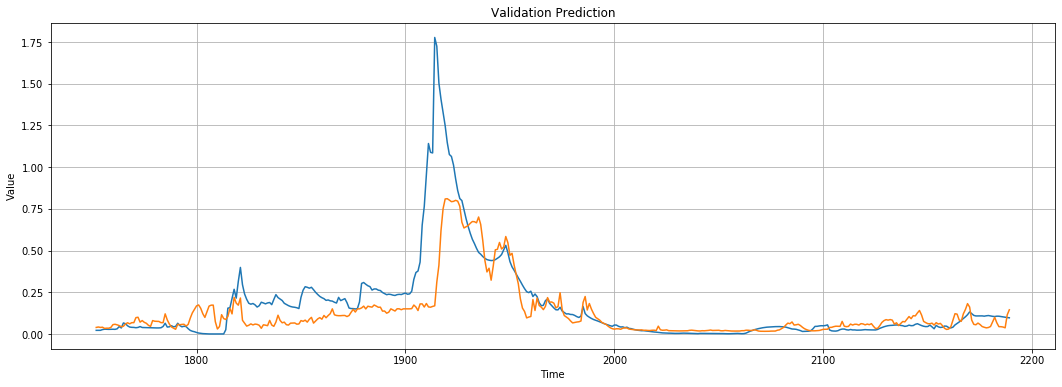

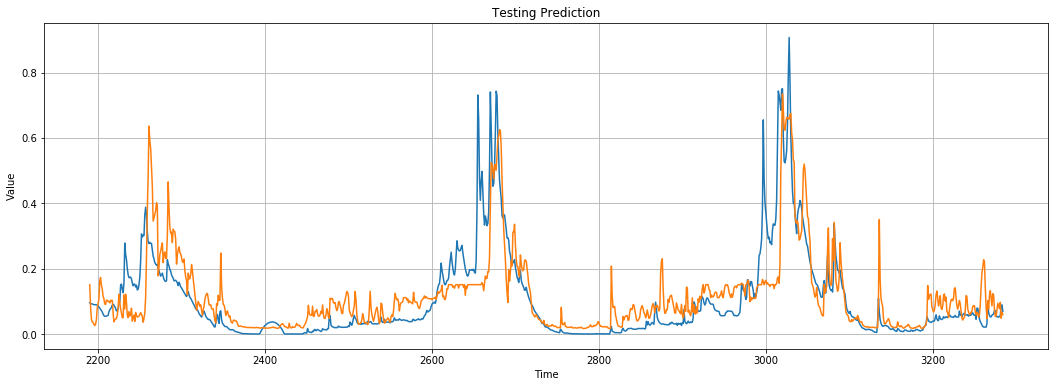

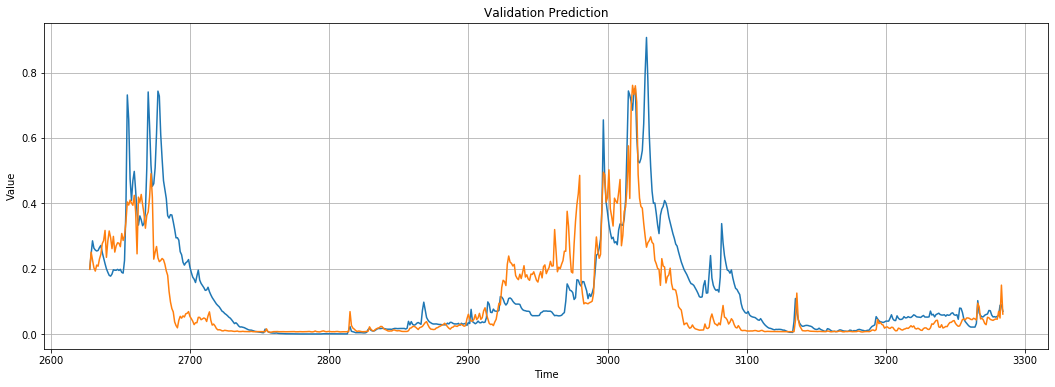

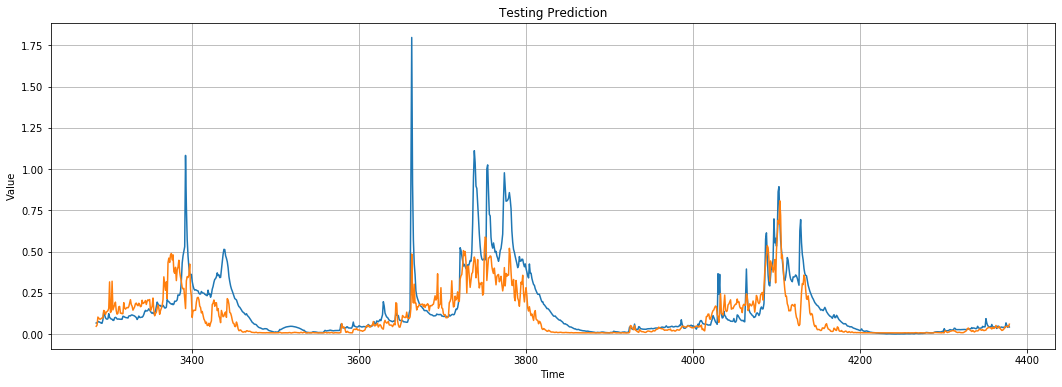

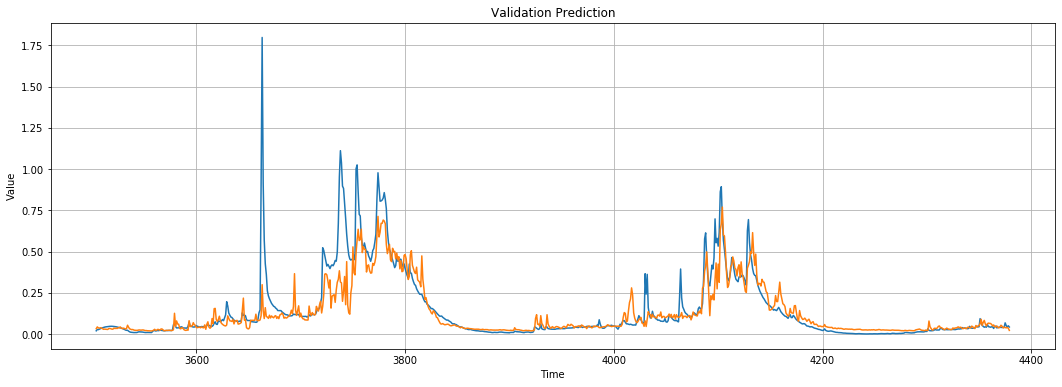

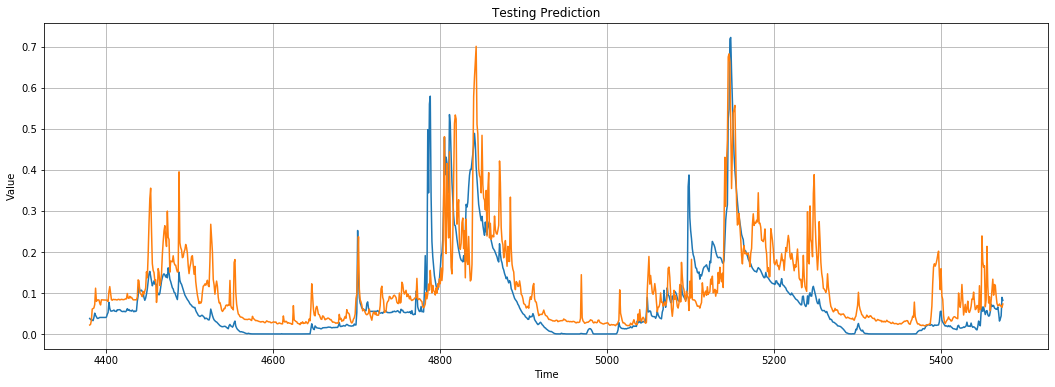

In [0]:
run_yrs(timeSteps = 5, optimizer = "adam", hidden_layer = 0, dropout = 1, dense = 1, plot = True, batch_size = 8, lost_function = 'mean_squared_logarithmic_error', neurons = 50)

#### Overall Parameters Performance:

In [0]:
# Load for a loooong time
def testing_parameters(plot):
  TimeSteps = [0, 1, 2, 5, 10]
  Neurons = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
  Optimizer = ['adam', 'sgd', 'Adagrad', 'Adadelta', 'RMSProp', 'Nadam']
  Dropout = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  HiddenLayer = [0, 1, 2, 3, 4, 5]
  Dense = [0, 1, 2, 3, 4, 5]
  BatchSize = [1, 8, 16, 32, 64]
  LostFunction = ['mean_squared_error', 'mean_absolute_error', 'mean_squared_logarithmic_error']
  MinError = 1000

  for i in TimeSteps:
    timeSteps = i
    for j in Neurons:
      neurons = j
      for h in Optimizer:
        optimizer = h
        for g in Dropout:
          dropout = g
          for v in HiddenLayer:
            hidden_layer = v
            for m in Dense:
              dense = m
              for n in BatchSize:
                batch_size = n
                for s in LostFunction:
                  print("\n============================",
                        "\nTime Step:", i, 
                        "\nNeuron:", j,
                        "\nOptimizer:", h,
                        "\nDropout:", g,
                        "\nHidden Layer:", v,
                        "\nDense:", m,
                        "\nBatch Size:", n,
                        "\nLost Function:", s)
                  lost_function = s
                  error = run_yrs(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons)
                  if error <= MinError:
                    MinError = error
                    I = i
                    J = j
                    H = h
                    G = g
                    V = v
                    M = m
                    N = n
                    S = s

  print("\n\n=========== Result ===========",
        "\nMinimun Error:", MinError,
        "\nTimeSteps:", I,
        "\nNeurons:", J,
        "\nOptimizer:", H,
        "\nDropout:", G,
        "\nHidden Layer:", V,
        "\nDense:", M,
        "\nBatch Size:", N,
        "\nLost Function:", S)

In [0]:
'''
Assumption:
TimeStep - 1
Optimizer - 'adam'
BatchSize - 8
LostFunction - 'NS' xxxxx only support build-in lost function
'''

def testing_parameters(plot):
  TimeSteps = [1]
  Neurons = [5, 15, 25, 35]
  Optimizer = ['adam']
  Dropout = [0.3, 0.5, 0.7]
  HiddenLayer = [0, 1, 2]
  Dense = [1, 2, 3]
  BatchSize = [8]
  LostFunction = ['mean_absolute_error']
  MaxNS = -1000

  for i in TimeSteps:
    timeSteps = i
    for j in Neurons:
      neurons = j
      for h in Optimizer:
        optimizer = h
        for g in Dropout:
          dropout = g
          for v in HiddenLayer:
            hidden_layer = v
            for m in Dense:
              dense = m
              for n in BatchSize:
                batch_size = n
                for s in LostFunction:
                  print("\n============================",
                        "\nTime Step:", i, 
                        "; Neuron:", j,
                        "; Optimizer:", h,
                        "; Dropout:", g,
                        "; Hidden Layer:", v,
                        "; Dense:", m,
                        "; Batch Size:", n,
                        "; Lost Function:", s)
                  lost_function = s
                  error = run_yrs(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons)
                  if error >= MaxNS:
                    MaxNS = error
                    I = i
                    J = j
                    H = h
                    G = g
                    V = v
                    M = m
                    N = n
                    S = s

  print("\n\n=========== Result ===========",
        "\nOptimal NS(largest):", MaxNS,
        "\nTimeSteps:", I,
        "\nNeurons:", J,
        "\nOptimizer:", H,
        "\nDropout:", G,
        "\nHidden Layer:", V,
        "\nDense:", M,
        "\nBatch Size:", N,
        "\nLost Function:", S)

In [0]:
testing_parameters(plot=False)


Time Step: 1 ; Neuron: 5 ; Optimizer: adam ; Dropout: 0.3 ; Hidden Layer: 0 ; Dense: 1 ; Batch Size: 8 ; Lost Function: mean_absolute_error


NameError: ignored

#### different timeStep performance:

In [0]:
def testing_timeStep(optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons):
  TimeStep = [1, 2, 5, 10]
  for i in TimeStep:
    print("TimeStep:", i)
    timeSteps = i
    error = run_yrs(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons)

In [0]:
testing_timeStep(optimizer = 'adam', hidden_layer = 0, dropout = 1, dense = 1, plot = False, batch_size = 8, lost_function = 'mean_squared_logarithmic_error')

**Result:**

1 | 2 | 5 | 10 
------|--------|-------|--------
0.1272 | 0.1343 | 0.142 | 0.1644

#### different optimizer performance:

In [0]:
def testing_optimizer(timeSteps, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons):
  Optimizer = ['adam', 'sgd', 'Adagrad', 'Adadelta', 'RMSProp', 'Nadam']
  for i in Optimizer:
    print("Optimizer:", i)
    optimizer = i
    error = run_yrs(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons)

In [0]:
testing_optimizer(timeSteps = 1, hidden_layer = 0, dropout = 1.0, dense = 1, plot = False, batch_size = 8, lost_function = 'mean_squared_error', neurons = 50)

**Result:**

Adam | sgd | Adagrad | Adadelta | RMSProp | Nadam | 
------|--------|-------|--------|---------|-------|
0.1214 | 0.1319 | 0.0977 | 0.099 | 0.0984 | 0.1198 |


#### different dropout rate performance:

In [0]:
def testing_dropout(timeSteps, optimizer, hidden_layer, dense, plot, batch_size, lost_function, neurons):
  Dropout = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  for i in Dropout:
    print("Dropout:", i)
    dropout = i
    error = run_yrs(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons)

In [0]:
testing_dropout(timeSteps = 1, optimizer = 'Adagrad', hidden_layer = 0, dense = 1, plot = False, batch_size = 8, lost_function = 'mean_squared_error', neurons = 50)

**Result:**

0.1 | 0.2 | 0.3 | 0.4 | 0.5 | 0.6 | 0.7 | 0.8 | 0.9 | 1.0
------|--------|-------|--------|---------|-------|-----|----|----|---|
0.1468 | 0.1801 | 0.2093 | 0.1858 | 0.2529 | 0.2752 | 0.2826 | 0.2864 | 0.2896 | 0.1383


#### different hidden layer performance:

In [0]:
def testing_hidden_layer(timeSteps, optimizer, dropout, dense, plot, batch_size, lost_function, neurons):
  HiddenLayer = [0, 1, 2, 3, 4, 5]
  for i in HiddenLayer:
    print("Hidden Layer:", i)
    hidden_layer = i
    error = run_yrs(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons)

In [0]:
testing_hidden_layer(timeSteps = 1, optimizer = 'adam', dropout = 1.0, dense = 1, plot = False, batch_size = 1, lost_function = 'mean_squared_error', neurons = 50)

**Result:**

0 | 1 | 2 | 3 | 4 | 5 |
------|--------|-------|--------|---------|--------|
0.1547 | 0.2488 | 0.306 | 0.2979 | 0.2687 |  0.2979  |

#### different dense number performance:

In [0]:
def testing_dense(timeSteps, optimizer, hidden_layer, dropout, plot, batch_size, lost_function, neurons):
  Dense = [0, 1, 2, 3, 4, 5]
  for i in Dense:
    print("Dense:", i)
    dense = i
    error = run_yrs(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons)

In [0]:
testing_dense(timeSteps = 1, optimizer = 'adam', hidden_layer = 0, dropout = 1.0, plot = False, batch_size = 1, lost_function = 'mean_squared_error', neurons = 50)

**Result:**

0 | 1 | 2 | 3 | 4 | 5 |
------|--------|-------|--------|---------|--------|
 |  |  |  |  |       |

#### different batch size performance:

In [0]:
def testing_batch_size(timeSteps, optimizer, hidden_layer, dropout, dense, plot, lost_function, neurons):
  BatchSize = [1, 8, 16, 32, 64]
  for i in BatchSize:
    print("Batch Size:", i)
    batch_size = i
    error = run_yrs(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons)

In [0]:
testing_batch_size(timeSteps = 1, optimizer = 'adam', hidden_layer = 0, dropout = 0.8, dense = 1, plot = False, lost_function = 'mean_squared_error', neurons = 50)

**Result:**

1 | 8 | 16 | 32 | 64 | 
------|--------|-------|--------|---------|
  |  |  |  |  |

#### different lost function performance:

In [0]:
def testing_lost_function(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, neurons):
  LostFunction = ['mean_squared_error', 'mean_absolute_error', 'mean_squared_logarithmic_error']
  for i in LostFunction:
    print("Lost Function:", i)
    lost_function = i
    error = run_yrs(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons)

In [0]:
testing_lost_function(timeSteps = 1, optimizer = 'adam', hidden_layer = 0, dropout = 0.8, dense = 1, plot = False, batch_size = 8, neurons = 50)

**Result:**

mean squared error | mean absolute error | mean_squared_logarithmic_error
-------------------| --------------------| ------------------------------
0.3313             |       0.3243        |       0.3128

#### different neurons number performance:

In [0]:
def testing_neuron(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function):
  Neuron = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
  for i in Neuron:
    print("Neuron:", i)
    neurons = i
    error = run_yrs(timeSteps, optimizer, hidden_layer, dropout, dense, plot, batch_size, lost_function, neurons)

In [0]:
testing_neuron(timeSteps = 1, optimizer = 'adam', hidden_layer = 0, dropout = 0.8, dense = 1, plot = False, batch_size = 8, lost_function = 'mean_squared_logarithmic_error')

**Result:**

5 | 10 | 15 | 20 | 25 | 30 | 35 | 40 | 45 | 50 | 55 | 60
--|----|----|----|----|----|----|----|----|----|----|----
  |  |  |  |  |  |  |  |  |  |

## Conclusion



## Prediction Model

In [0]:
run_final_model(timeSteps = 1, optimizer = "adam", hidden_layer = 0, dropout = 1, dense = 1, plot = True, batch_size = 8, lost_function = 'mean_squared_logarithmic_error', neurons = 50)